# Implementation and evaluation of a computational standardization pipeline for chemical compounds
## Based on ["Trust, But Verify: On the Importance of Chemical Structure Curation in Cheminformatics and QSAR Modeling Research" from 2010 (D. Fourches, ...)"](https://pubmed.ncbi.nlm.nih.gov/20572635/)


### Introduction 
This notebook serves to showcase the functionality of the Standardization module. Following the recommended standardization steps of "Trust, But Verify"(D. Fourches, ..., 2010).
This notebook uses the dataset of following paper: [Cheminformatics Analysis of Assertions Mined from Literature That Describe Drug-Induced Liver Injury in Different Species](https://pubs.acs.org/doi/10.1021/tx900326k)

<span style='color:red'> For all relative paths in this notebook to work, please make sure you are starting this notebook from the working directory ./opencadd/docs/tutorials/  </span><br>
Check your directory with the cell below.

In [1]:
import os
os.getcwd()

'/home/allen/dev/opencadd/docs/tutorials'

In [2]:
#Import pandas and numpy
import pandas as pd
import numpy as np

#import modules and Standardization API functions needed
from rdkit import Chem
#from rdkit.Chem.PandasTools import RemoveSaltsFromFrame
from opencadd.compounds.standardization import convert_format,handle_fragments,disconnect_metals,detect_inorganic,remove_salts,normalize,handle_tautomers

In [3]:
# Helper function to mark at which step the entry failed the standardization pipeline
def failMarker(i):
    i=taskNum
    return i

### Initial dataset import and cleaning of empty entries
------------------------------------------------
The first step before the standardization steps are started is a import of the dataset as an Pandas Dataframe, only including the columns necessary. In this case we use the <b>IDs</b>, <b>Names</b> and <b>SMILEs</b> column.<br>
Then we search for all entries which actually don't have any strings saved under <b>SMILEs</b> and kick them from the dataset, since they are not holding any information.<br>
After the import we add a <b>Failed_at</b> column to track in which standardization step the entry failed. 
The intial `taskNum` will be 0, which leads to an default <b>Failed_at</b>-value of 0 for all entries, where null stands for <i>not failed</i> . 

In [4]:
taskNum = 0

# Importing the test-dataset 
dataset = pd.read_csv (r'./data/standardization_test_data.csv')

#Filter for needed columns
dataset = dataset[['IDs','Names','SMILEs']]

#Kick all empty entries
empty_smiles = dataset[(dataset['SMILEs'].isnull())] 
# The empty_smiles dataframe could be used to check which entires are affected and review the dataset again.
dataset = dataset[(dataset['SMILEs'].notna())]

#Setting a initial score of 0 for all entries in the 'Failed_at'-column
dataset['Failed_at'] = dataset['SMILEs'].apply(failMarker)


#Show the current form of the main-dataframe
dataset.tail()

,IDs,Names,SMILEs,Failed_at
199,200,Citric acid,OC(=O)CC(O)(CC(O)=O)C(O)=O,0
200,201,zirconium,CCO[Zr](OCC)(OCC)OCC,0
201,202,hemoglobin,CC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C=C5C(=C(C(=...,0
202,203,test_salt,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,0
203,204,test_duplicate,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,0


### Step 1: Conversion of SMILEs to mol
------------------------------------------
### Convert the SMILE representation format of the compounds into Mol-files

RDKit performs a sanitization of the molecule by default. In this sanitization step RDKit tries to kekulize the mols (generates alternate Lewis structures). This step might fail, when the structure is aromatic, but no Hydrogen position is provided. TODO:!(This explanation might be a bit short and not fully correct, check this later again)!

If the conversion from SMILE to mol fails, then those SMILEs will get a <b>Failed_at</b> marker added. 

To avoid the sanitization of the molecule `convert_smiles_to_mol` can be called with the argument `sanitize=False`. Keep in mind that the generation of different Lewis structures serves to find different representation formats of the same molecule. 

References:<br>
https://chemistry.stackexchange.com/questions/116498/what-is-kekulization-in-rdkit<br>
https://rdkit-discuss.narkive.com/QwnqcKcM/another-can-t-kekulize-mol-observation<br>
https://www.rdkit.org/docs/Cookbook.html<br>
https://www.rdkit.org/docs/source/rdkit.Chem.rdmolfiles.html<br>


#### Task 1: Convert to Mol

In [5]:
# Setting up the taskNum
taskNum = 1

# A column called mol is beeing added to the dataframe to store the mol-files
dataset['mol'] = dataset['SMILEs'].apply(convert_format.convert_smiles_to_mol)

#test set
test_numpy = dataset


# All entries which couldn't generate a mol will get filtered another dataframe
failed_step_1 = dataset[(dataset['mol'].isnull())]
failed_step_1['Failed_at'] = failed_step_1['Failed_at'].apply(failMarker)
failed_step_1 = failed_step_1[['IDs','Names','SMILEs','Failed_at']]

# Update the dataset by removing all entries without a mol
result1 = dataset[dataset['mol'].notna()]
test_numpy.head(16)


RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 7 9
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7 8 10 11 12
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 6 8 10
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 57 58 60
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 23
RDKit ERROR: 
RDKit ERROR: [14:36:22] Can't kekulize mol.  Unkekulized atoms: 11 12 13 15 16 17 19 20 21
RDKit ERROR: 
<ipython-input-5-1379bc743ce6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,IDs,Names,SMILEs,Failed_at,mol
0,1,(R)-Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1.[Ca],0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d83f0>
1,2,17-Methyltestosterone,CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>
2,3,1-alpha-Hydroxycholecalciferol,CC(C)CCCC(C)C1CCC2C(CCCC12C)=CC=C1CC(O)CC(O)C1=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>
3,4,"2,3-Dimercaptosuccinic acid",OC(=O)C(S)C(S)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>
4,5,"2,4,6-Trinitrotoluene",Cc1c(cc(cc1N(=O)=O)N(=O)=O)N(=O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>
5,6,2-Deoxy-D-glucose,OCC1OC(O)CC(O)C1O.O1CCOCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f30>
6,7,2'-fluoro-5-methylarabinosyluracil,CC1=CN(C2OC(CO)C(O)C2F)C(=O)NC1=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f80>
7,8,2-Methoxyestradiol,COc1cc2C3CCC4(C)C(O)CCC4C3CCc2cc1O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349030>
8,9,4-aminobenzoic acid,Nc1ccc(cc1)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349080>
9,10,4-Hydroxytamoxifen,CCC(c1ccccc1)=C(c1ccc(O)cc1)c1ccc(OCCN(C)C)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593490d0>


In [6]:
#Testing numpy.where

#df = test_numpy

#df['Failed_at'] = np.where((df['mol'].isnull()),df['Failed_at'].apply(failMarker), df['Failed_at'])
#df['Inorganics'] = np.where((df['Failed_at'].isnull()),df['mol'].apply(detect_inorganic),None)
#df['new_test'] = np.where((df["Failed_at"].isnull()),df['SMILEs'].apply(handle_tautomers.canonicalize_tautomer),df['Failed_at'])
#df.head(50)

### Step 2: Removal of Inorganics and Mixtures
--------------------------------------------------

Since molecular descriptors can only be computed for organic compunds, all inorganic compunds must be removed before the descriptors are calculated. (Chapter 2.1. Fourches 2010)

For the flagging and following removal of compounds containing inorganic molecules, we can use the function `detect_inorganic`. This function returns a boolean value of "True" when it finds a inorganic molecule. We can run this flagging in a pre-processing step of the data, and discard those compounds. 
"Inorganic compounds are known to have biological effects, like for example toxic effects."(Chapter 2.1. Fourches 2010)(fix citation)
 Due to their potential bioactivity we can not distinguish if the recored activity of a mixed compound is caused by it's organic or inorganic part. Therefore the entry is useless and can be discarded. ! THIS SHOULD BE LOGGED AND MANUAL CURATION SHOULD BE ENABLED !
An alternate and easy way would be that every SMILES  is undertaken a substring search, where a match of a inorganic compound pattern (search pattern set should be defined) would be  flagged.

Due to the fact, that the treatment is not as simple as it apprears the paper (Fourches, 2010) recommends to delete records containing mixtures. ! THIS AGAIN CAN BE LOGGED AND MANUAL CURATION CAN BE DONE WITH THIS SET ! The ease up the curation various filtering functions can be implemented to help decide which to keep and which to discard. Three types of mixtures are described. ! CHECK IF IMPLEMENTATION WOULD BE POSSIBLE EASY AND FAST ! Common and widely used practice is to retain molecules with the highest molecular weight or the largest number of atoms(Chapter 2.1. Fourches 2010), but the paper (Fourches, 2010) states this might not be the best solution, and further investigation in mixtures should only be done if there is a reason to belive that the biological activity is really caused by the largest molecule and not the mixture itself.

Those actions might be performed, before the entered SMILES are beeing converted into mol-files. Some described steps are related to string pattern searches.

#### Task 2: Filter entries with inorganic components

In [7]:
# Setting up the taskNum 
taskNum = 2
# getting the valid entries from the step before
dataset = result1

# Check for inorganic structures in the entries
dataset['Inorganics'] = dataset['mol'].apply(detect_inorganic)

# Filter the failed entries
failed_step_2 = dataset[dataset['Inorganics']== True]
failed_step_2['Failed_at'] = failed_step_2['Failed_at'].apply(failMarker)

# Safe entries that passed
result2 = dataset[dataset['Inorganics']== False]
failed_step_2.tail(15)

<ipython-input-7-c7d7bae360cc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Inorganics'] = dataset['mol'].apply(detect_inorganic)
<ipython-input-7-c7d7bae360cc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_step_2['Failed_at'] = failed_step_2['Failed_at'].apply(failMarker)


,IDs,Names,SMILEs,Failed_at,mol,Inorganics
0,1,(R)-Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1.[Ca],2,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d83f0>,True
114,115,Bortezomib,CC(C)CC(NC(=O)C(Cc1ccccc1)NC(=O)c1cnccn1)B(O)O,2,<rdkit.Chem.rdchem.Mol object at 0x7f2c59342260>,True
200,201,zirconium,CCO[Zr](OCC)(OCC)OCC,2,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344da0>,True
201,202,hemoglobin,CC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C=C5C(=C(C(=...,2,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344df0>,True
202,203,test_salt,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,2,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344e40>,True
203,204,test_duplicate,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,2,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344e90>,True


#### Task 3: Filter entries containing fragments

In [8]:
# Setting up the taskNum 
taskNum = 3
# getting the valid entries from the step before
dataset = result2

# Perform remove_fragments on entries
dataset['mol_after'] = dataset['mol'].apply(handle_fragments.remove_fragments)

# Create Smiles for evaluation
dataset['smiles_before'] = dataset['mol'].apply(convert_format.convert_mol_to_smiles)

# Create new SMILEs from the current state for evaluation of performed changes 
dataset['Smiles 3'] = dataset['mol_after'].apply(convert_format.convert_mol_to_smiles)
dataset['noChanges']= dataset['smiles_before'] == dataset['Smiles 3']


# Filter the failed entries
failed_step_3 = dataset[dataset['noChanges']== False]
failed_step_3['Failed_at'] = failed_step_3['Failed_at'].apply(failMarker)

# Safe entries that passed
result3 = dataset[dataset['noChanges']== True]
result3 = result3[['IDs','Names','SMILEs','Failed_at','mol']]
failed_step_3.tail()



RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Removed fragment: 1,4-dioxane
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit I

,IDs,Names,SMILEs,Failed_at,mol,Inorganics,mol_after,smiles_before,Smiles 3,noChanges
5,6,2-Deoxy-D-glucose,OCC1OC(O)CC(O)C1O.O1CCOCC1,3,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f30>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c5936ee90>,C1COCCO1.OCC1OC(O)CC(O)C1O,OCC1OC(O)CC(O)C1O,False


#### Task 4: Filter entires containing metals

In [9]:
# Setting up the taskNum 
taskNum = 4
# getting the valid entries from the step before
dataset = result3[['IDs','Names','SMILEs','Failed_at','mol']] #Load result1 subset to actually see this step perform

# Create Smiles for evaluation
dataset['smiles_before'] = dataset['mol'].apply(convert_format.convert_mol_to_smiles)

# Perform disconnect_metals on entries
dataset['mol_after'] = dataset['mol'].apply(disconnect_metals)

# Create new SMILEs from the current state for evaluation of performed changes 
dataset['Smiles 4'] = dataset['mol_after'].apply(convert_format.convert_mol_to_smiles)
dataset['noChanges']= dataset['smiles_before'] == dataset['Smiles 4']

# Filter the failed entries
failed_step_4 = dataset[dataset['noChanges']== False]
failed_step_4['Failed_at'] = failed_step_4['Failed_at'].apply(failMarker)
failed_step_4.tail()

# Safe entries that passed
result4 = dataset[dataset['noChanges']== True]
result4 = result4[['IDs','Names','SMILEs','Failed_at','mol']]
result4.tail()

RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [14:36:22] Running FragmentRemover
RDKit INFO: [

,IDs,Names,SMILEs,Failed_at,mol
195,196,Ciprofibrate,CC(C)(Oc1ccc(cc1)C1CC1(Cl)Cl)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344c10>
196,197,Ciprofloxacin,OC(=O)C1=CN(C2CC2)c2cc(N3CCNCC3)c(F)cc2C1=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344c60>
197,198,Cisapride,COC1CN(CCCOc2ccc(F)cc2)CCC1NC(=O)c1cc(Cl)c(N)c...,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344cb0>
198,199,Citalopram,CN(C)CCCC1(OCc2cc(ccc12)C#N)c1ccc(F)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344d00>
199,200,Citric acid,OC(=O)CC(O)(CC(O)=O)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344d50>


#### Task 5: Filter inorganics again  
<span style='color:red'>This step actually doesn't make much sense here, since no actual changes happend to the entries in this first step</span>


In [10]:
# Setting up the taskNum 
taskNum = 5
# getting the valid entries from the step before
dataset = result4

# Check for inorganic structures in the entries
dataset['Inorganics2'] = dataset['mol'].apply(detect_inorganic)

# Filter the failed entries
failed_step_5 = dataset[dataset['Inorganics2']== True]
failed_step_5['Failed_at'] = failed_step_5['Failed_at'].apply(failMarker)

# Safe entries that passed
result5 = dataset[dataset['Inorganics2']== False]
failed_step_5.tail(15)

,IDs,Names,SMILEs,Failed_at,mol,Inorganics2


### Step 3: Structural Conversion and Cleaning
--------------------------------------------------

Some drugs need to be transformed "into their salt form to enhance how the drug disscolves (...) and (to) increase it's effectiveness. (https://www.drugs.com/article/pharmaceutical-salts.html (03/12/21)) Therefore it is common for chemical compound databases to contain records of salts. If possible it is recommended to delete the records containing salts completely, since, similar to in-organic compounds, "most descriptor-generating software (can not process salts)" (Fourches 2010 Chapter 2.2 ).While not beeing desirable, it is still an acceptable procedure to convert compounds into their neutral forms. But cases like this should be tagged, filtered and afterwards manually curated or compared to the actual neutral form of that compound. 
In case that we want to continue working on the converted records, we should perform the following steps:
- check if records contain compounds with presence of metals --> difficult case, filter out (already done this - one step ahead)
- removing the salts from the record
- neutralize the record (normalization or basic standardization)
- neutralize the charges
- to be discussed: the adding/removing of hydrogens, both got pros and cons (pro addingH --> higher prediction performances / con addingH --> may introduce noise --> less reliable models)(removingH might introduce erros in calculating descriptors, due to it might not handle certain cases well)



In [11]:
# Structural coversion
# Cleaning/removal of salts
# Functions remove_salts
# normalize_molecules
# handle_charges
# handle_hydrogens

#### Task 6: Removing salts <span style='color:red'>sadly fails ATM</span>

In [12]:
# Setting up the taskNum 
taskNum = 6
# getting the valid entries from the step before
dataset = result1
#dataset.head(100)
dataset['removed_salts'] = dataset['mol'].map(remove_salts)
dataset.head(20)

#dataset['removed_salts'] = RemoveSaltsFromFrame(dataset,molCol='mol')
#where_salt = dataset[dataset['removed_salts'].notna()]

CC(=O)O
O=C(O)CC(O)(CC(=O)O)C(=O)O
[Zn]
[Zn]


<ipython-input-12-3b85c59a0368>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['removed_salts'] = dataset['mol'].map(remove_salts)


,IDs,Names,SMILEs,Failed_at,mol,Inorganics,removed_salts
0,1,(R)-Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1.[Ca],0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d83f0>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59365e90>
1,2,17-Methyltestosterone,CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>
2,3,1-alpha-Hydroxycholecalciferol,CC(C)CCCC(C)C1CCC2C(CCCC12C)=CC=C1CC(O)CC(O)C1=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>
3,4,"2,3-Dimercaptosuccinic acid",OC(=O)C(S)C(S)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>
4,5,"2,4,6-Trinitrotoluene",Cc1c(cc(cc1N(=O)=O)N(=O)=O)N(=O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>
5,6,2-Deoxy-D-glucose,OCC1OC(O)CC(O)C1O.O1CCOCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f30>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f30>
6,7,2'-fluoro-5-methylarabinosyluracil,CC1=CN(C2OC(CO)C(O)C2F)C(=O)NC1=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f80>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339f80>
7,8,2-Methoxyestradiol,COc1cc2C3CCC4(C)C(O)CCC4C3CCc2cc1O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349030>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349030>
8,9,4-aminobenzoic acid,Nc1ccc(cc1)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349080>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59349080>
9,10,4-Hydroxytamoxifen,CCC(c1ccccc1)=C(c1ccc(O)cc1)c1ccc(OCCN(C)C)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593490d0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c593490d0>


In [13]:
dataset['mol'][0:10].apply(remove_salts)

0    <rdkit.Chem.rdchem.Mol object at 0x7f2c5930e210>
1    <rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>
2    <rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>
3    <rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>
4    <rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>
5    <rdkit.Chem.rdchem.Mol object at 0x7f2c59339f30>
6    <rdkit.Chem.rdchem.Mol object at 0x7f2c59339f80>
7    <rdkit.Chem.rdchem.Mol object at 0x7f2c59349030>
8    <rdkit.Chem.rdchem.Mol object at 0x7f2c59349080>
9    <rdkit.Chem.rdchem.Mol object at 0x7f2c593490d0>
Name: mol, dtype: object

In [14]:
example = dataset['mol'].values[0]

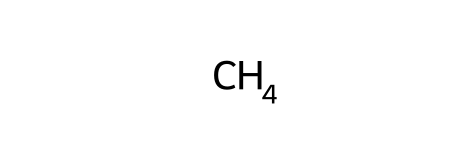

In [15]:
test = 'C.[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg].[Na].[Ag].[Sr].S.O.[Zn]'
mol = convert_format.convert_smiles_to_mol(test)
mol
salt_remover = remove_salts(mol)
salt_remover

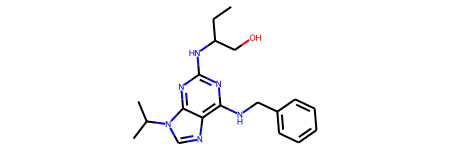

In [16]:
remove_salts(example)

#### Task 7: Normalize molecules

In [17]:
# Setting up the taskNum 
taskNum = 7
# getting the valid entries from the step before
dataset = result1
#dataset.head(100)
dataset['normalized'] = dataset['mol'].apply(normalize)
result7 = dataset
result7.head()

<ipython-input-17-e123c015a2c1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['normalized'] = dataset['mol'].apply(normalize)


,IDs,Names,SMILEs,Failed_at,mol,Inorganics,removed_salts,normalized
0,1,(R)-Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1.[Ca],0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d83f0>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59365e90>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d4170>
1,2,17-Methyltestosterone,CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d49e0>
2,3,1-alpha-Hydroxycholecalciferol,CC(C)CCCC(C)C1CCC2C(CCCC12C)=CC=C1CC(O)CC(O)C1=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d4a30>
3,4,"2,3-Dimercaptosuccinic acid",OC(=O)C(S)C(S)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592ea030>
4,5,"2,4,6-Trinitrotoluene",Cc1c(cc(cc1N(=O)=O)N(=O)=O)N(=O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592ead50>


#### Task 8: Charges and Hydrogens TODO

### Normalization of Specific Chemotypes

More complex than just Normalization.

In [18]:
# Normalization of specific chemotypes
# normalize_molecules

In [19]:
# Treatment of tautomeric forms
# handle_tautomers

#### Task 9: Generate a canonicalized tautomer on SMILEs entries

In [20]:
# Setting up the taskNum 
taskNum = 9

dataset = result7

# Find all duplicate occurences in SMILEs
dataset['canonicalized tautomer'] = dataset['SMILEs'].apply(handle_tautomers.canonicalize_tautomer)
dataset.head()

<ipython-input-20-0a29cb44f9d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['canonicalized tautomer'] = dataset['SMILEs'].apply(handle_tautomers.canonicalize_tautomer)


,IDs,Names,SMILEs,Failed_at,mol,Inorganics,removed_salts,normalized,canonicalized tautomer
0,1,(R)-Roscovitine,CCC(CO)Nc1nc(NCc2ccccc2)c2ncn(C(C)C)c2n1.[Ca],0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d83f0>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59365e90>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d4170>,CCC(C[O-])N=c1[nH]c(=N[CH-]c2ccccc2)c2ncn(C(C)...
1,2,17-Methyltestosterone,CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c593d43f0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d49e0>,CC12CCC(=O)C=C1CCC1C2CCC2(C)C1CCC2(C)O
2,3,1-alpha-Hydroxycholecalciferol,CC(C)CCCC(C)C1CCC2C(CCCC12C)=CC=C1CC(O)CC(O)C1=C,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339df0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592d4a30>,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(C)C)CC(O)CC1O
3,4,"2,3-Dimercaptosuccinic acid",OC(=O)C(S)C(S)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339e40>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592ea030>,O=C(O)C(S)C(S)C(=O)O
4,5,"2,4,6-Trinitrotoluene",Cc1c(cc(cc1N(=O)=O)N(=O)=O)N(=O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59339ee0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592ead50>,Cc1c([N+](=O)[O-])cc([N+](=O)[O-])cc1[N+](=O)[O-]


In [21]:
dataset.tail()

,IDs,Names,SMILEs,Failed_at,mol,Inorganics,removed_salts,normalized,canonicalized tautomer
199,200,Citric acid,OC(=O)CC(O)(CC(O)=O)C(O)=O,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344d50>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344d50>,<rdkit.Chem.rdchem.Mol object at 0x7f2c5930edf0>,O=C(O)CC(O)(CC(=O)O)C(=O)O
200,201,zirconium,CCO[Zr](OCC)(OCC)OCC,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344da0>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344da0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c5930ec60>,CC[O-].CC[O-].CC[O-].CC[O-].[Zr+4]
201,202,hemoglobin,CC1=C(C2=CC3=NC(=CC4=C(C(=C([N-]4)C=C5C(=C(C(=...,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344df0>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344df0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c5930eee0>,C=CC1=C(C)c2cc3[n-]c(cc4[nH]c(cc5nc(cc1n2)C(C)...
202,203,test_salt,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344e40>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c592ccd50>,<rdkit.Chem.rdchem.Mol object at 0x7f2c5930eda0>,Br.Cl.F.I.N.O.S.[Ag].[Al].[Ba].[Bi].[Ca+2].[K+...
203,204,test_duplicate,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,0,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344e90>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59365f30>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592c1490>,Br.Cl.F.I.N.O.S.[Ag].[Al].[Ba].[Bi].[Ca+2].[K+...


### Removal of duplicates

In [22]:
# Analysis/removal of duplicates

# Setting up the taskNum 
taskNum = 10

dataset = result7

# Find all duplicate occurences in SMILEs
dataset['duplicate?'] = dataset.duplicated(subset=['SMILEs'])

#Filter the duplicates out
failed_step_10 = dataset[dataset['duplicate?']== True]
failed_step_10['Failed_at'] = failed_step_10['Failed_at'].apply(failMarker)

dataset = dataset[dataset['duplicate?']== False]
failed_step_10.tail()


<ipython-input-22-913a98ebf4f6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['duplicate?'] = dataset.duplicated(subset=['SMILEs'])
<ipython-input-22-913a98ebf4f6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_step_10['Failed_at'] = failed_step_10['Failed_at'].apply(failMarker)


,IDs,Names,SMILEs,Failed_at,mol,Inorganics,removed_salts,normalized,canonicalized tautomer,duplicate?
168,169,Cerivastatin sodium,COCc1c(nc(C(C)C)c(C=CC(O)CC(O)CC(O)=O)c1-c1ccc...,10,<rdkit.Chem.rdchem.Mol object at 0x7f2c593443f0>,False,<rdkit.Chem.rdchem.Mol object at 0x7f2c593443f0>,<rdkit.Chem.rdchem.Mol object at 0x7f2c59308440>,COCc1c(-c2ccc(F)cc2)c(=CCC(O)CC(O)CC(=O)O)c(C(...,True
203,204,test_duplicate,[Al].N.[Ba].[Bi].Br.[Ca].Cl.F.I.[K].[Li].[Mg]....,10,<rdkit.Chem.rdchem.Mol object at 0x7f2c59344e90>,True,<rdkit.Chem.rdchem.Mol object at 0x7f2c59365f30>,<rdkit.Chem.rdchem.Mol object at 0x7f2c592c1490>,Br.Cl.F.I.N.O.S.[Ag].[Al].[Ba].[Bi].[Ca+2].[K+...,True


In [23]:
# Manual inspection

In [24]:
#Contatination of results for the end 
test = pd.concat([failed_step_1,failed_step_2])
test = test.sort_values(by=['IDs'])
